- assign species labels based on sample filters (genotype filters ignored for now)
- species label co-occurence within clusters
- majority rule species prediction
- look at species prediction disagreements

Manual steps: none

In [1]:
%run common.ipynb

In [2]:
# sequencing data
seq_data = pd.read_csv(CLUSTERING)
seq_data.shape

(10057, 10)

## Species labels on clusters

In [3]:
# filter sequencing data
hq_seq_data = seq_data[(seq_data.species != 'unknown')]# &
#                        (~seq_data.outlier_genotype) & 
#                        (~seq_data.split_alleles)]
hq_seq_data.shape

(9589, 10)

In [4]:
cl_sp_pred = hq_seq_data.groupby('ag1k_cluster')['species'].unique()
cl_sp_pred.head()

ag1k_cluster
cl-0-0                              [Anopheles_barbirostris]
cl-0-1     [Anopheles_coluzzii, Anopheles_arabiensis, Ano...
cl-0-10                             [Anopheles_rhodesiensis]
cl-0-11    [Anopheles_brohieri, Anopheles_demeilloni, Ano...
cl-0-13                                [Anopheles_annularis]
Name: species, dtype: object

## Taxonomic orders

This section uses species tree data from the next notebook

In [5]:
# DEPRECATED: get taxonomically meaningful species ordering
# tax_order = pd.read_csv(TAXONOMY_FILE, index_col=0) \
#               .sort_values(by=['subgenus','series','group','complex','species_ncbi']) 
# # subset to studied species
# sh_order = tax_order[tax_order.index.isin(spp_sharing.columns)].index

In [6]:
# read & reorder tree
t = ete3.Tree(SPECIES_TREE)
t.set_outgroup(t.get_common_ancestor('Anopheles_bellator','Anopheles_cruzii'))
t.ladderize(direction=1)
# get species names
spp_order = [leaf.name for leaf in t]  + ['unknown','Unclassified_cluster']
# read taxonomy
taxonomy = pd.read_csv(TAXONOMY_FILE)
# subser species
def get_spp(name, rank):
    tax_spp = taxonomy.loc[taxonomy[rank] == name, 'species'].to_list()
    return [sp for sp in spp_order if sp in tax_spp]

# key groups
group_orders = {
    # subgenera - use basal divergence only
    'Kerteszia_subgenus':get_spp('Kerteszia', 'subgenus'),
    'Anopheles_subgenus':get_spp('Anopheles', 'subgenus'),
    'Nyssorhynchus_subgenus':get_spp('Nyssorhynchus', 'subgenus'),
    'Cellia_subgenus':get_spp('Cellia', 'subgenus'),
    # series - use basal divergence only
    'Myzomyia_series':get_spp('Myzomyia', 'series'),
    'Neocellia_series':get_spp('Neocellia', 'series'),
    'Pyretophorus_series':get_spp('Pyretophorus', 'series'), 
    'Neomyzomyia_series':get_spp('Neomyzomyia', 'series')
}
group_orders['Neomyzomyia_series']

['Anopheles_jebudensis',
 'Anopheles_rhodesiensis',
 'Anopheles_cracens',
 'Anopheles_dirus_A',
 'Anopheles_balabacensis',
 'Anopheles_farauti',
 'Anopheles_koliensis',
 'Anopheles_punctulatus',
 'Anopheles_tessellatus',
 'Anopheles_nili_ss',
 'Anopheles_nili',
 'Anopheles_carnevalei',
 'Anopheles_dureni',
 'Anopheles_vinckei']

In [7]:
# reorder samples according to taxonomy
sample_order = list()
for sp in spp_order:
    sample_order.extend(seq_data.loc[seq_data.species == sp, 's_Sample'].unique())
len(sample_order)

161

## Fancy species labels

In [8]:
# all species
all_spp = set(np.concatenate(cl_sp_pred.to_list()))

In [9]:
# labels
spp_labels = dict()
for sp in all_spp:
    pretty_sp = sp.replace('Anopheles_','An. ')
    samples = hq_seq_data.loc[hq_seq_data.species == sp, 's_Sample'].drop_duplicates()
    n_ref = samples.str.startswith('anopheles').sum()
    n_seq = samples.shape[0] - n_ref
    spp_labels[sp] = "{} {}+{}".format(pretty_sp, n_seq, n_ref)
spp_labels['Anopheles_gambiae']

'An. gambiae 5+2'

## Fancy sample labels

In [10]:
# sample labels
sample_labels = dict()
for sample in seq_data.s_Sample.unique():
    sample_seq = seq_data[seq_data['s_Sample'] == sample]
    nseq = sample_seq.shape[0]
    try:
        species = spp_labels[sample_seq['species'].iloc[0]].split(' ')[1]
    except:
        # excluded samples
        if sample.startswith('Adem'):
            species = 'unknown'#': demeilloni'
        elif sample.startswith('Amar'):
            species = 'unknown'#': marschallii'
        elif sample.startswith('Apal'):
            species = 'unknown'#': paludis'
        elif sample == 'VBS00084':
            species = 'unknown'#': hyrcanus'
        elif sample == 'VBS00145':
            species = 'unknown'#': sundaicus'
        else:
            raise ValueError(sample)
    # shorten reference names
    if sample.startswith('anopheles'):
        # contigs/scaffolds + assembly name
        if sample[-7] == 's':
            sample_label = sample[-6:]
        # other - trim 
        else:
            sample_label = sample.split('-')[-1]
    else:
        sample_label = sample
    sample_labels[sample] = '{} ({}, {} seq)'.format(sample_label, species, nseq)
sample_labels['Aory-SP141']

'Aory-SP141 (oryzalimnetes, 16 seq)'

## Frequencies of species label combinaitons within clusters

In [11]:
# clusters with multiple species
mixed_cls = cl_sp_pred[cl_sp_pred.apply(lambda x: len(x) > 1)]

In [12]:
# all species encountered in mixed clusters
all_mixed_spp = set(np.concatenate(mixed_cls.to_list()))
# pairwise combinations dataframe
spp_sharing = pd.DataFrame(0, index=all_spp, columns=all_spp)

In [13]:
# fill
for cl in mixed_cls:
    for (sp1, sp2) in itertools.combinations(cl, 2):
        spp_sharing.loc[sp1, sp2] += 1
# make diagonal symmetrical
spp_sharing = (spp_sharing + spp_sharing.T)
spp_sharing.loc[group_orders['Pyretophorus_series'],group_orders['Pyretophorus_series']]

,Anopheles_coluzzii,Anopheles_gambiae,Anopheles_arabiensis,Anopheles_quadriannulatus,Anopheles_melas,Anopheles_merus,Anopheles_christyi,Anopheles_epiroticus,Anopheles_sundaicus,Anopheles_vagus
Anopheles_coluzzii,0,77,56,54,52,49,3,3,3,6
Anopheles_gambiae,77,0,58,56,52,49,3,3,3,6
Anopheles_arabiensis,56,58,0,48,47,46,3,3,3,6
Anopheles_quadriannulatus,54,56,48,0,46,42,3,3,3,6
Anopheles_melas,52,52,47,46,0,43,3,3,3,6
Anopheles_merus,49,49,46,42,43,0,3,1,2,5
Anopheles_christyi,3,3,3,3,3,3,0,2,2,2
Anopheles_epiroticus,3,3,3,3,3,1,2,0,51,18
Anopheles_sundaicus,3,3,3,3,3,2,2,51,0,19
Anopheles_vagus,6,6,6,6,6,5,2,18,19,0


In [14]:
# exclusive species clusters at diagonal
single_cls = cl_sp_pred[cl_sp_pred.apply(lambda x: len(x) == 1)]
single_cls = single_cls.apply(lambda x: x[0])
for (sp, count) in single_cls.value_counts().to_dict().items():
    spp_sharing.loc[sp,sp] = count
spp_sharing.loc[group_orders['Pyretophorus_series'],group_orders['Pyretophorus_series']]

,Anopheles_coluzzii,Anopheles_gambiae,Anopheles_arabiensis,Anopheles_quadriannulatus,Anopheles_melas,Anopheles_merus,Anopheles_christyi,Anopheles_epiroticus,Anopheles_sundaicus,Anopheles_vagus
Anopheles_coluzzii,5,77,56,54,52,49,3,3,3,6
Anopheles_gambiae,77,8,58,56,52,49,3,3,3,6
Anopheles_arabiensis,56,58,2,48,47,46,3,3,3,6
Anopheles_quadriannulatus,54,56,48,4,46,42,3,3,3,6
Anopheles_melas,52,52,47,46,5,43,3,3,3,6
Anopheles_merus,49,49,46,42,43,8,3,1,2,5
Anopheles_christyi,3,3,3,3,3,3,44,2,2,2
Anopheles_epiroticus,3,3,3,3,3,1,2,1,51,18
Anopheles_sundaicus,3,3,3,3,3,2,2,51,9,19
Anopheles_vagus,6,6,6,6,6,5,2,18,19,38


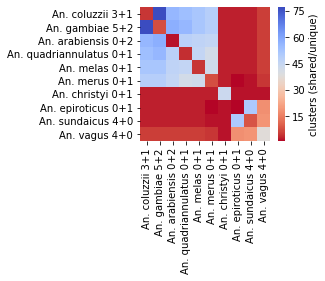

In [15]:
pyret_sharing = spp_sharing.loc[group_orders['Pyretophorus_series'], group_orders['Pyretophorus_series']].copy()
pyret_sharing = pyret_sharing.rename(columns=spp_labels, index=spp_labels)
fig, ax = plt.subplots(1,1,figsize=(4.5,4))
sns.heatmap(pyret_sharing, cmap='coolwarm_r', ax=ax, cbar_kws={'label': 'clusters (shared/unique)'});
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
# plt.savefig('data/fig3b.pdf')
plt.show()

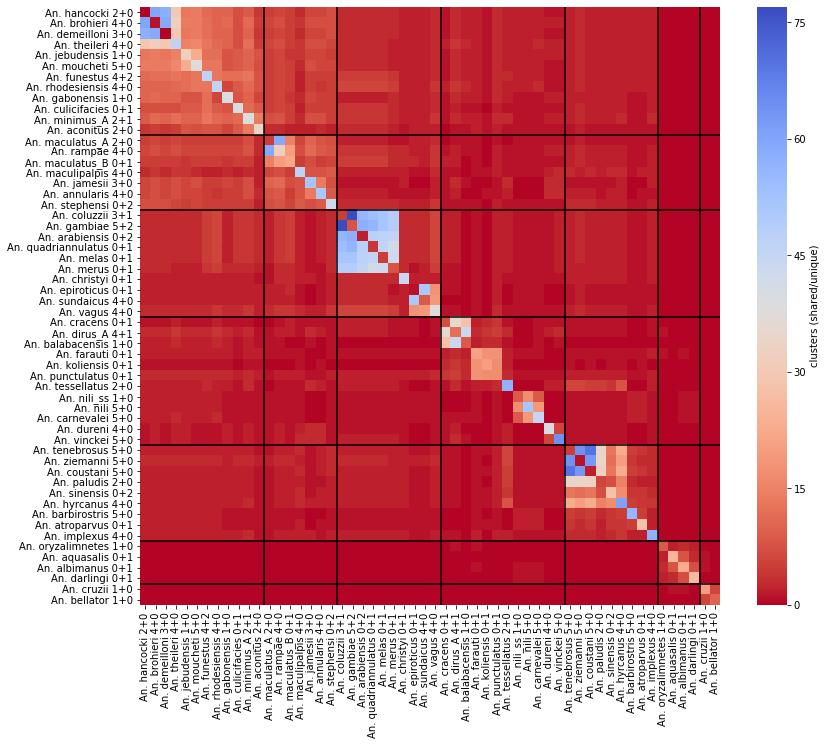

In [16]:
# reorder to taxonomically sound order
d = spp_sharing.reindex(index=spp_order, columns=spp_order).copy()
d = d.rename(columns=spp_labels, index=spp_labels)
d = d.dropna(how='all', axis=1).dropna(how='all', axis=0)
# for col in d.columns:
#     d[col] = d[col] / d[col].max()
fig, ax = plt.subplots(1,1,figsize=(13,11))
sns.heatmap(d, cmap='coolwarm_r', ax=ax, cbar_kws={'label': 'clusters (shared/unique)'})
# split groups
for i in (12, 19, 29, 41, 50, 54):
    ax.axhline(i,c='k')
    ax.axvline(i,c='k')
# plt.tight_layout()
plt.show()

Co-occurence of species within complexes is very common. Number/proportion of shared clusters can be used as an indicator of species proximity (e.g., in gambiae complex).

## Predict species for all samples

In [17]:
cl_sp_pred = cl_sp_pred.to_dict()

In [18]:
def accumulate_sp_predictions(sample):
    
    s_preds = list()
    # clusters for sample
    sample_cl = seq_data.loc[seq_data.s_Sample == sample, 
                            'ag1k_cluster'].to_list()
    for cl in sample_cl:
        # get species labels for cluster
        try:
            s_preds.extend(cl_sp_pred[cl])
        # no labels for cluster
        except:
            s_preds.append('Unclassified_cluster')
    # label counts
    return(pd.Series(s_preds).value_counts())
accumulate_sp_predictions('VBS00149').head()

Anopheles_tessellatus    72
Anopheles_hyrcanus        7
Anopheles_tenebrosus      5
Anopheles_ziemanni        5
Anopheles_paludis         4
dtype: int64

In [19]:
%%time
species_predictions = dict()
sample_meta = pd.read_csv(COMB_META)
for sample in sample_order:
    species_predictions[sample] = accumulate_sp_predictions(sample)

CPU times: user 353 ms, sys: 6.85 ms, total: 360 ms
Wall time: 382 ms


In [20]:
def get_top_pred(x):
    try:
        return species_predictions[x].index[0]
    except:
        return 'No_sequencing_data'

sample_meta['species_prediction'] = sample_meta.s_Sample.apply(get_top_pred)

In [21]:
sample_meta[sample_meta.species_prediction == 'No_sequencing_data']

,s_Sample,External ID,Date of Collection,Location,Country,Latitude,Longitude,Species,Collection Context,Collection Method,Collection Time,Specimen Sex,Specimen Type,Extraction Method,Sample Type,Sample Set,Source,species_prediction
45,Abru-12,12,2015-08-06,Lopé,Gabon,-0.19124,11.59327,Anopheles_brunnipes,Outdoors,Human Landing Catch,NaN,Female,Wild caught adult,QIAGEN,Genomic DNA,ga,run1,No_sequencing_data
48,Amac-47,47,2016-02-11,Lopé,Gabon,-0.19124,11.59327,Anopheles_maculipalpis,Outdoors,Human Landing Catch,NaN,Female,Wild caught adult,QIAGEN,Genomic DNA,ga,run1,No_sequencing_data


## Write species predictions

In [22]:
# write out complete predictions table
species_predictions = pd.DataFrame(species_predictions)
species_predictions.fillna(0).astype(int).T.to_csv(SPP_PRED)

## visualise all species predictions

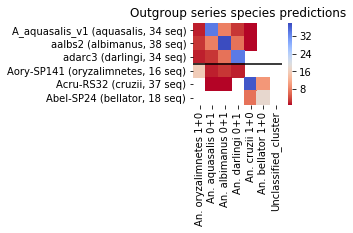

In [23]:
def heatmap_spp_preds(spp, group, samples=None, split_ref=True):
    spp = list(spp) + ['Unclassified_cluster']
    if not samples:
        samples = seq_data.loc[seq_data.species.isin(spp), 's_Sample'].unique()
    sc = species_predictions.columns
    if split_ref:
        samples_ref = [s for s in samples if s.startswith('anoph')]
        samples_ref = sc[sc.isin(samples_ref)]
        samples_seq = [s for s in samples if not s.startswith('anoph')]
        samples_seq = sc[sc.isin(samples_seq)]
        samples = list(samples_ref) + list(samples_seq)
    else:
        samples = sc[sc.isin(samples)]
    pred = species_predictions.loc[spp, samples] \
        .rename(index=spp_labels, columns=sample_labels).T
    fig, ax = plt.subplots(1,1, 
                           figsize=(len(spp) / 3.5,
                                    len(samples) / 4))
    sns.heatmap(pred, 
                cmap='coolwarm_r', 
                ax=ax);
    if split_ref:
        ax.axhline(len(samples_ref), c='k')
    ax.set_title('{} species predictions'.format(group))
heatmap_spp_preds(group_orders['Nyssorhynchus_subgenus'] + group_orders['Kerteszia_subgenus'], 'Outgroup series')

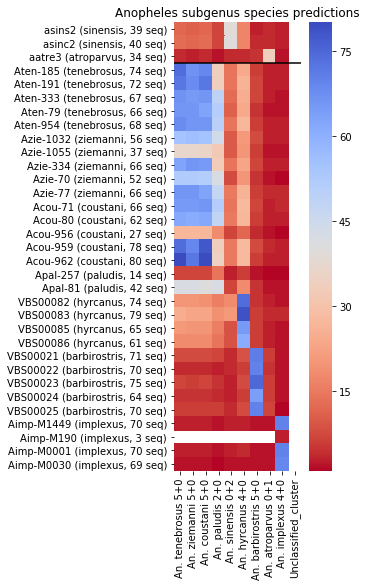

In [24]:
heatmap_spp_preds(group_orders['Anopheles_subgenus'], 'Anopheles subgenus', split_ref=True)

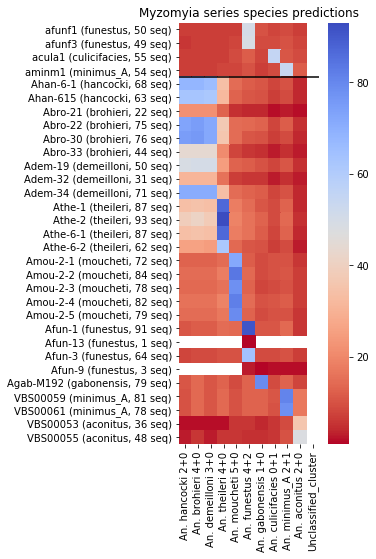

In [25]:
heatmap_spp_preds(group_orders['Myzomyia_series'], 'Myzomyia series')

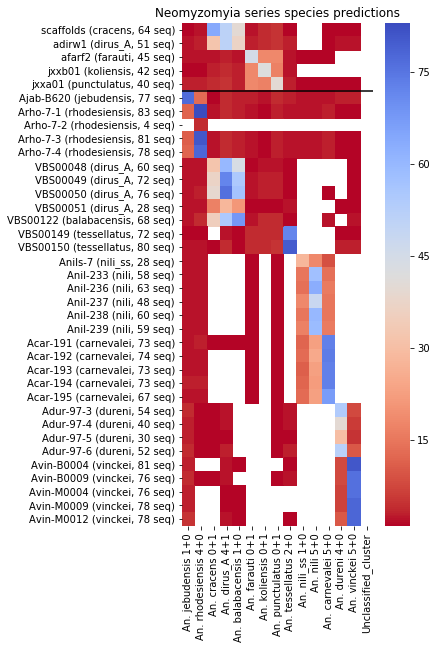

In [26]:
heatmap_spp_preds(group_orders['Neomyzomyia_series'], 'Neomyzomyia series')

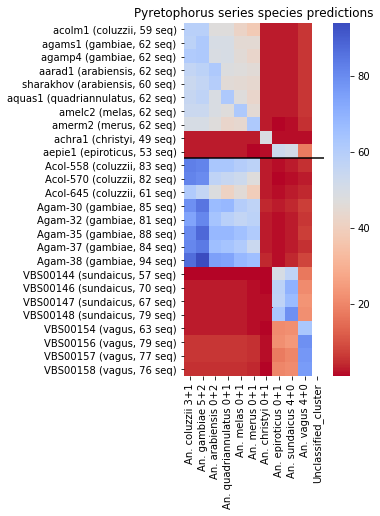

In [27]:
heatmap_spp_preds(group_orders['Pyretophorus_series'], 'Pyretophorus series')

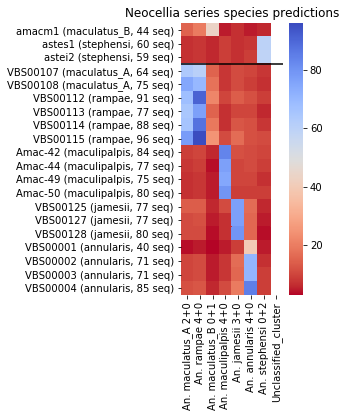

In [28]:
heatmap_spp_preds(group_orders['Neocellia_series'], 'Neocellia series')

## Species prediction disagreements within labelling dataset

In [29]:
# majority rule species prediction disagreeents
spp_disagreements = sample_meta.loc[sample_meta.species_prediction != sample_meta.Species, 
                                   ['s_Sample','Species', 'species_prediction']]
# TODO remove samples not in reference dataset
spp_disagreements.shape

(25, 3)

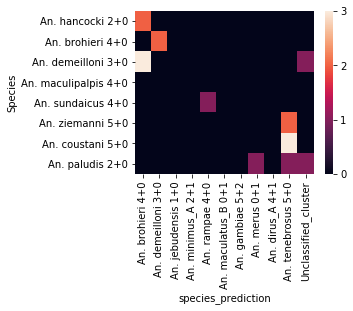

In [30]:
spd = spp_disagreements.groupby("Species")['species_prediction'].value_counts().unstack().fillna(0)
spd = spd.reindex(columns=spp_order, index=spp_order) \
         .dropna(how='all', axis=0) \
         .dropna(how='all', axis=1) \
         .rename(columns=spp_labels, index=spp_labels)
fig, ax = plt.subplots(1,1,figsize=(4,3))
sns.heatmap(spd,
            cbar_kws=dict(ticks=range(5)));

Most disagreements are between closely related species:
- coustani-tenebrosus-ziemanni
- brohieri-demeilloni-hancocki
- gambiae-coluzzii

Two species are unreliable - marshalli and paludis.

# Species predictions for samples excluded from species labelling dataset

In [31]:
nonref_samples = seq_data.loc[seq_data.species == 'unknown', 's_Sample'].unique()
nonref_samples

array(['Adem-15', 'Amar-3-1', 'Amar-42', 'Amar-5', 'Apal-10', 'Apal-4',
       'VBS00084', 'VBS00145'], dtype=object)

In [32]:
nonref_preds = sample_meta.loc[sample_meta.s_Sample.isin(nonref_samples), 
                                   ['s_Sample','Species', 'species_prediction']]
nonref_preds.shape

(8, 3)

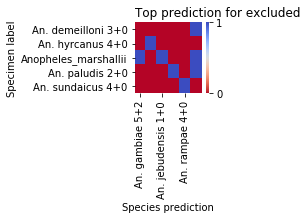

In [33]:
nrd = nonref_preds.groupby("Species")['species_prediction'].value_counts().unstack().fillna(0)
# x_order = tax_order[tax_order.index.isin(nrd.columns)].index.to_list() + ['Unclassified_cluster']
# y_order = tax_order[tax_order.index.isin(nrd.index)].index
# nrd = nrd.loc[y_order, x_order]
nrd = nrd.rename(columns=spp_labels, index=spp_labels)
fig, ax = plt.subplots(1,1,figsize=(1.5,1.3))
sns.heatmap(nrd, cmap='coolwarm_r',
            cbar_kws=dict(ticks=range(5)));
plt.ylabel('Specimen label')
plt.xlabel('Species prediction')
# plt.savefig('data/fig3c.pdf')
plt.title('Top prediction for excluded', loc='left')

plt.show()

In [34]:
# accumulate top-5 species predictions for new samples
top_spp = list()
n_species = 6
min_clusters = 1
for sample in nonref_samples:
    tp = species_predictions[sample].sort_values(ascending=False).iloc[:n_species]
    tp = tp[tp >= min_clusters].index.to_list()
    top_spp.extend(tp)
top_spp = [sp for sp in spp_order if sp in top_spp]

Text(0.5, 1, 'Excluded samples predictions')

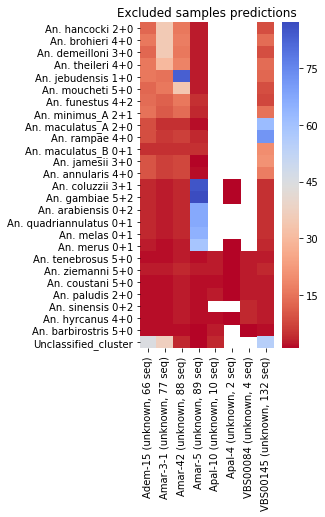

In [39]:
# samples = seq_data.loc[seq_data.species.isin(spp), 's_Sample'].unique()
pred = species_predictions.loc[top_spp, nonref_samples] \
    .rename(index=spp_labels, columns=sample_labels)
fig, ax = plt.subplots(1,1, figsize=(3,6))
sns.heatmap(pred, 
            cmap='coolwarm_r', 
            ax=ax);
ax.set_title('Excluded samples predictions')

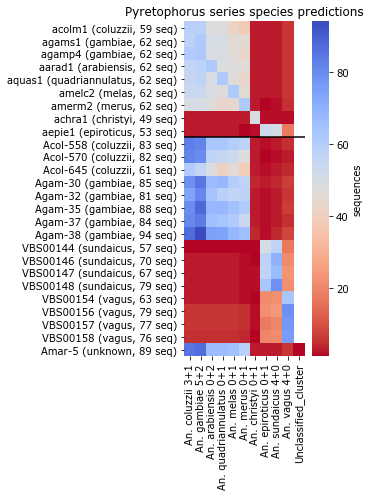

In [62]:
spp = group_orders['Pyretophorus_series']
# separately subset seq & ref
samples_seq = seq_data.loc[seq_data.species.isin(spp) & 
                           ~seq_data.s_Sample.str.startswith('anop'), 's_Sample'].unique()
samples_ref = seq_data.loc[seq_data.species.isin(spp) & 
                           seq_data.s_Sample.str.startswith('anop'), 's_Sample'].unique()
# reorder according to 
samples_seq = species_predictions.columns[species_predictions.columns.isin(samples_seq)]
samples_ref = species_predictions.columns[species_predictions.columns.isin(samples_ref)]
# remove unpublished ref
samples_ref = [s for s in samples_ref if s != 'anopheles-arabiensis-sharakhov']
samples = list(samples_ref) + list(samples_seq) + ['Amar-5']
pred = species_predictions.loc[spp + ['Unclassified_cluster'], samples] \
    .rename(index=spp_labels, columns=sample_labels)
fig, ax = plt.subplots(1,1,figsize=(5, 7))
sns.heatmap(pred.T, 
            cmap='coolwarm_r',
            cbar_kws={'label': 'sequences'},
            ax=ax);
ax.axhline(len(samples_ref), c='k')
# ax.axhline(len(samples_seq) + len(samples_ref), c='k')
ax.set_title('Pyretophorus series species predictions')
plt.tight_layout()
plt.savefig('data/fig3b.pdf')
plt.show()

# combined figure

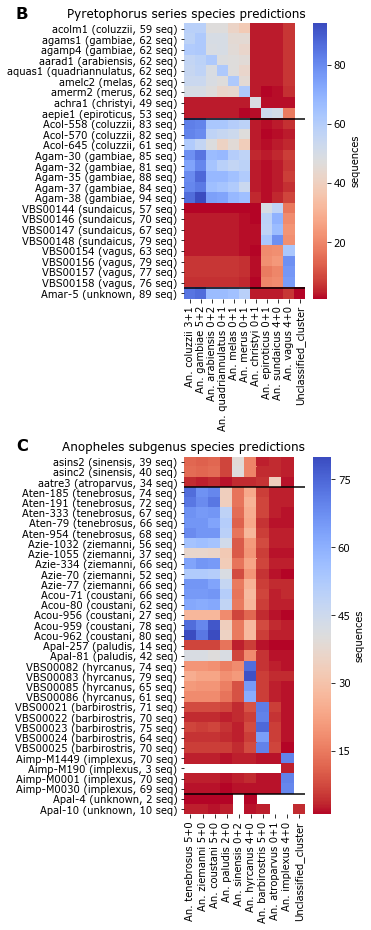

In [57]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Verdana']

########################
spp = group_orders['Pyretophorus_series']
# separately subset seq & ref
samples_seq = seq_data.loc[seq_data.species.isin(spp) & 
                           ~seq_data.s_Sample.str.startswith('anop'), 's_Sample'].unique()
samples_ref = seq_data.loc[seq_data.species.isin(spp) & 
                           seq_data.s_Sample.str.startswith('anop'), 's_Sample'].unique()
# reorder samples
samples_seq = species_predictions.columns[species_predictions.columns.isin(samples_seq)]
samples_ref = species_predictions.columns[species_predictions.columns.isin(samples_ref)]
# remove unpublished ref
samples_ref = [s for s in samples_ref if s != 'anopheles-arabiensis-sharakhov']
# add unidentified sample
samples = list(samples_ref) + list(samples_seq) + ['Amar-5']
pred_pyr = species_predictions.loc[spp + ['Unclassified_cluster'], samples] \
    .rename(index=spp_labels, columns=sample_labels)

########################
spp = group_orders['Anopheles_subgenus']
# separately subset seq & ref
samples_seq = seq_data.loc[seq_data.species.isin(spp) & 
                           ~seq_data.s_Sample.str.startswith('anop'), 's_Sample'].unique()
samples_ref = seq_data.loc[seq_data.species.isin(spp) & 
                           seq_data.s_Sample.str.startswith('anop'), 's_Sample'].unique()
# reorder samples
samples_seq = species_predictions.columns[species_predictions.columns.isin(samples_seq)]
samples_ref = species_predictions.columns[species_predictions.columns.isin(samples_ref)]
# add unidentified samples
samples = list(samples_ref) + list(samples_seq) + ['Apal-4', 'Apal-10']
pred_ano = species_predictions.loc[spp + ['Unclassified_cluster'], samples] \
    .rename(index=spp_labels, columns=sample_labels)

####################
fig, (ax1, ax2) = plt.subplots(2,1,
                               figsize=(5, 13),
                               gridspec_kw={'height_ratios':(1,1.3)})

sns.heatmap(pred_pyr.T, 
            cmap='coolwarm_r',
            cbar_kws={'label': 'sequences'},
            ax=ax1);
for i in (9,25):
    ax1.axhline(i, c='k')

sns.heatmap(pred_ano.T, 
            cmap='coolwarm_r',
            cbar_kws={'label': 'sequences'},
            ax=ax2);
for i in (3,33):
    ax2.axhline(i, c='k')

ax1.set_title('Pyretophorus series species predictions', loc='right')
ax2.set_title('Anopheles subgenus species predictions', loc='right')
    
plt.tight_layout()

for label, ax, yloc in zip('B C'.split(), (ax1, ax2), (1.06, 1.05)):
    ax.text(-1.3, yloc, label, transform=ax.transAxes,
          fontsize=16, fontweight='bold', va='top', ha='right')


plt.savefig('data/fig3bc.pdf')
plt.show()

In [38]:
# fig, (ax1, ax2) = plt.subplots(2,1, 
#                                figsize=(4.5, 12),
#                               gridspec_kw={'height_ratios':(1,2.5)})

# sns.heatmap(pyret_sharing, 
#             cmap='coolwarm_r', 
#             ax=ax1, 
#             cbar_kws={'label': 'clusters'})
# ax1.set_xlabel('')
# ax1.set_ylabel('')
# ax1.set_title('Species-specific and shared clusters')#, loc='left')

# sns.heatmap(sppred_nonref, 
#             cmap='coolwarm_r',
#             ax=ax2,
#             cbar_kws={'label': 'sequences'})
# ax2.set_xlabel('Specimen')
# ax2.set_ylabel('Species predictions')
# ax2.set_title('Species predictions for excluded samples')#, loc='left')

# plt.tight_layout();

# for label, ax, yloc in zip('B C'.split(), (ax1, ax2), (1.13, 1.05)):
#     ax.text(-1.4, yloc, label, transform=ax.transAxes,
#           fontsize=16, fontweight='bold', va='top', ha='right')

